In [1]:
import torch
import torch_scatter
import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import json

In [2]:
from utilss import benchmark, save_to_json, load_from_json, sort_by_and_plot
from apsp import FW_GPU, R_Kleene

In [3]:
torch.cuda.device_count()

1

In [8]:
# #### Random Graph Generator ####
# def graph_gen(num_nodes=10, density_controller=.9, cost_magnitude_controller=100):
#     cuda0 = torch.device('cuda:0')
#     dc= density_controller # less than one makes it sparser, greater than one makes it denser
#     cmc = cost_magnitude_controller # controls the magnitude of the costs

#     dense_adj = torch.bernoulli(torch.clamp(dc*torch.rand(num_nodes, num_nodes), max=1.0)).to(cuda0).int()
#     dense_adj[torch.arange(num_nodes), torch.arange(num_nodes)] = 0
#     num_edges = dense_adj.sum() # count the total number of edges generated in this graph

#     costs = (cmc * torch.rand(dense_adj.shape).to(cuda0))#.int()
#     costs[~dense_adj.bool()] = torch.inf 
#     costs[torch.arange(num_nodes), torch.arange(num_nodes)] = 0
    
#     return costs, num_edges.item()

# ### Converter to nx Graph
# def convert_to_nxg(H):

#     H_sparse = H.to_sparse()
#     edge_index, weight = H_sparse.indices().cpu().numpy(), H_sparse.values().cpu().numpy()
#     edge_and_weights = [(edge[0], edge[1], w) for edge, w in zip(edge_index.T, weight.T)]

#     g = nx.Graph()
#     g.add_weighted_edges_from(edge_and_weights)

#     return g

# #### FLOYD WARSHALL ALGS ####
# def FW_GPU(H):
#     found = False
#     while not found:
#         H_prime, pred = FW_iter(H.clone())
#         if (H_prime == H).all():
#             found=True
#         H = H_prime
#     return {'cost': H, 'pred': pred}

# def FW_iter(costs):
#     threeD = costs + costs.T.unsqueeze(1)
#     updated_costs, updated_vias = torch.min(threeD, dim=2)
#     updated_costs, updated_vias = updated_costs.T, updated_vias.T
#     return updated_costs, updated_vias

# #### R-KLEENE ALGS ####
# def min_plus_GPU(A, B, C=None):
#     threeD = A + B.T.unsqueeze(1)
#     updated_costs, updated_vias = torch.min(threeD, dim=2)
#     updated_costs, updated_vias = updated_costs.T, updated_vias.T
#     if C is None:
#         return updated_costs #, updated_vias
#     else:
#         return torch.minimum(updated_costs, C) #, updated_vias

# def R_Kleene(H):
#     h,w = H.shape
#     assert h == w, 'The input cost matrix should be square'
#     assert (H >= 0).any(), "The input cost matrix shouldn't have negative costs "
#     assert (torch.diagonal(H) == 0).all(), 'The input cost matrix should have a zero diagonal'

#     # base case
#     if h <= 2:
#         return H

#     # recursive case
#     cut_point = h//2
#     A = H[:cut_point, :cut_point]
#     B = H[:cut_point, cut_point:]
#     C = H[cut_point:, :cut_point]
#     D = H[cut_point:, cut_point:]

#     A = R_Kleene(A);          # recursive call, compute path lengths within A
#     B = min_plus_GPU(A,B);    # B = A*B;       now B includes paths through A
#     C = min_plus_GPU(C,A);    # C = C*A;       now C includes paths through A
#     D = min_plus_GPU(C,B,D);  # D = D + C*B;   now D includes paths through A
#     D = R_Kleene(D);          # recursive call, compute path lengths within D
#     B = min_plus_GPU(B,D);    # B = B*D;       now B includes paths through D
#     C = min_plus_GPU(D,C);    # C = D*C:       now C includes paths through D
#     A = min_plus_GPU(B,C,A);  # A = A + B*C;   now A includes paths through D

#     result = torch.cat([ torch.cat([A, B], dim=1), torch.cat([C, D], dim=1) ], dim=0)
#     return result

# #### BENCHMARKING #######
# def benchmark(num_exps=500, max_nodes=1000, max_density=100, do_nx=False):

#     num_nodess = torch.randint(4,max_nodes,size=(1,num_exps)).flatten()
#     densities = torch.randint(0,max_density,size=(1,num_exps)).flatten() * torch.rand(num_exps)
#     num_edgess = num_exps * [None]

#     fw_cc, rkl_cc, nx_cc = num_exps * [None], num_exps * [None], num_exps * [None]
#     inconsistencies_kl_fw, inconsistencies_nx_rkl, inconsistencies_nx_fw = num_exps * [None], num_exps * [None], num_exps * [None]

#     for exp, (num_nodes, density) in enumerate(zip(num_nodess, densities)):
#         H, num_edges = graph_gen(num_nodes=num_nodes, density_controller=density) 
#         num_edgess[exp] = num_edges

#         curr = time.time()
#         H_fw = FW_GPU(H.clone())['cost']
#         fw_cc[exp] = time.time() - curr
#         #H_fw = torch.round(H_fw) #, decimal=2)

#         curr = time.time()
#         H_rkl = R_Kleene(H.clone())
#         rkl_cc[exp] = time.time() - curr
#         #H_rkl = torch.round(H_rkl) #, decimal=2)

#         if do_nx:
#             g = convert_to_nxg(H)
#             curr = time.time()
#             H_nx = nx.floyd_warshall_numpy(g)
#             nx_cc[exp] = time.time() - curr

#             H_nx = torch.Tensor(H_nx).to(H.device)

#             inconsistency_nx_fw = torch.nn.functional.mse_loss(H_nx, H_fw)
#             inconsistencies_nx_fw[exp] = inconsistency_nx_fw.item()
            
#             inconsistency_nx_rkl = torch.nn.functional.mse_loss(H_nx, H_rkl)
#             inconsistencies_nx_rkl[exp] = inconsistency_nx_rkl.item()

#         #assert (H_rkl == H_fw).all(), 'Inconsistent Results between GPU algs!'
#         inconsistency_kl_fw = torch.nn.functional.mse_loss(H_rkl, H_fw)
#         inconsistencies_kl_fw[exp] = inconsistency_kl_fw.item()


#     # Format
#     num_nodess = num_nodess.cpu().numpy()
#     num_edgess = np.array(num_edgess)

#     rkl_cc = np.array(rkl_cc)
#     fw_cc = np.array(fw_cc)
#     nx_cc = np.array(nx_cc)

#     inconsistencies_kl_fw = np.array(inconsistencies_kl_fw)
#     inconsistencies_nx_fw = np.array(inconsistencies_nx_fw)
#     inconsistencies_nx_rkl = np.array(inconsistencies_nx_rkl)

#     return {'graph_specs': [num_nodess, num_edgess], 'time_costs': [rkl_cc, fw_cc, nx_cc], 'inconsistencies': [inconsistencies_kl_fw, inconsistencies_nx_fw, inconsistencies_nx_rkl]}

# def sort_by_and_plot(big_dict, sort_by='nodes', do_nx=False, exp_slice=None): # num_nodess, num_edgess, rkl_cc, fw_cc, inconsistencies,
#     num_nodess, num_edgess = big_dict['graph_specs']
#     rkl_cc, fw_cc, nx_cc = big_dict['time_costs']
#     inconsistencies_kl_fw, inconsistencies_nx_fw, inconsistencies_nx_rkl = big_dict['inconsistencies']

#     if exp_slice is None:
#         start, stop = 0, num_nodess.shape[0]
#     else:
#         start, stop = exp_slice

#     # Sort
#     if sort_by == 'nodes':
#         sorting_idxs = np.argsort(num_nodess)
#     elif sort_by == 'edges':
#         sorting_idxs = np.argsort(num_edgess)
#     num_nodess = num_nodess[sorting_idxs][start:stop]
#     num_edgess = num_edgess[sorting_idxs][start:stop]
#     rkl_cc = rkl_cc[sorting_idxs][start:stop]
#     fw_cc = fw_cc[sorting_idxs][start:stop]
#     nx_cc = nx_cc[sorting_idxs][start:stop]
#     inconsistencies_kl_fw = inconsistencies_kl_fw[sorting_idxs][start:stop]
#     inconsistencies_nx_fw = inconsistencies_nx_fw[sorting_idxs][start:stop]
#     inconsistencies_nx_rkl = inconsistencies_nx_rkl[sorting_idxs][start:stop]

#     # Plots
#     plt.figure()
#     plt.plot(num_nodess, label='num nodes of graph')
#     plt.plot(np.sqrt(num_edgess), label='num edges of graph in sqrt scale')
#     plt.xlabel('graph/exp number')
#     plt.ylabel('amount')
#     plt.title('Showing graph statistics of each graph-experimental-sample')
#     plt.legend()
#     plt.show()

#     plt.figure()
#     graph_densities = num_edgess / ((num_nodess**2) - num_nodess)
#     plt.plot(graph_densities, label='graph density')
#     plt.xlabel('graph/exp number')
#     plt.ylabel('Graph Density')
#     plt.title('Showing connectivity/density of each graph-experiment-sample')
#     plt.legend()
#     plt.show()

#     plt.figure()
#     plt.plot(fw_cc, label='FW_GPU() time costs')
#     plt.plot(rkl_cc, label='R_Kleene_GPU() time costs')
#     if do_nx:
#         plt.plot(nx_cc, label='FW_CPU_NX() time costs')
#     plt.xlabel('graph/exp number')
#     plt.ylabel('time cost in seconds')
#     plt.title('Comparing Time Costs of APSP Implementations')
#     plt.legend()
#     plt.show()

#     plt.figure()
#     plt.plot(inconsistencies_kl_fw, label='between FW_GPU() and R_Kleene_GPU()')
#     if do_nx:
#         plt.plot(inconsistencies_nx_fw, label='between FW_CPU_NX() and FW_GPU()')
#         plt.plot(inconsistencies_nx_rkl, label='between FW_CPU_NX() and R_Kleene_GPU()')
#     plt.xlabel('graph/exp number')
#     plt.ylabel('Average Mean Squared Error(MSE)')
#     plt.title('Quantifying Inconsitencies Between APSP Implementations')
#     plt.legend()
#     plt.show()

# def save_to_json(big_dict):
#     new_big_dict = {}
#     new_big_dict['graph_specs'] = [big_dict['graph_specs'][0].tolist(), big_dict['graph_specs'][1].tolist()]
#     new_big_dict['time_costs'] = [big_dict['time_costs'][0].tolist(), big_dict['time_costs'][1].tolist(), big_dict['time_costs'][2].tolist()]
#     new_big_dict['inconsistencies'] =  [big_dict['inconsistencies'][0].tolist(), big_dict['inconsistencies'][1].tolist(), big_dict['inconsistencies'][2].tolist()]

#     # write result big_dict to json
#     with open("big_dict.json","w") as f:
#         json.dump(new_big_dict,f)

# def load_from_json():
#     with open('big_dict.json') as json_file:
#         big_dict = json.load(json_file)

#     new_big_dict = {}
#     new_big_dict['graph_specs'] = [np.array(big_dict['graph_specs'][0]), np.array(big_dict['graph_specs'][1])]
#     new_big_dict['time_costs'] = [np.array(big_dict['time_costs'][0]), np.array(big_dict['time_costs'][1]), np.array(big_dict['time_costs'][2])]
#     new_big_dict['inconsistencies'] =  [np.array(big_dict['inconsistencies'][0]), np.array(big_dict['inconsistencies'][1]), np.array(big_dict['inconsistencies'][2])]

#     return new_big_dict

In [4]:
A = torch.Tensor([  [0, 5, torch.inf, 10],
                    [torch.inf, 0, 3, torch.inf],
                    [torch.inf, torch.inf, 0, 1],
                    [torch.inf, torch.inf, torch.inf, 0] ])

In [67]:
do_nx = True
big_dict = benchmark(num_exps=1000, max_nodes=1000, max_density=100, do_nx=do_nx)
save_to_json(big_dict)

In [3]:
big_dict = load_from_json('big_dict2.json')

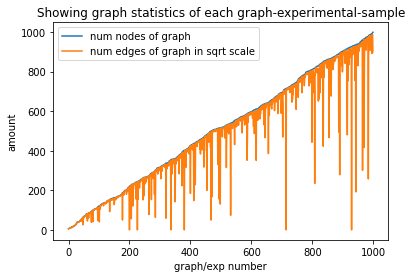

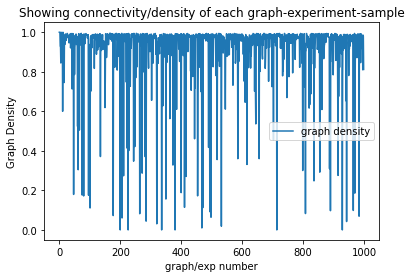

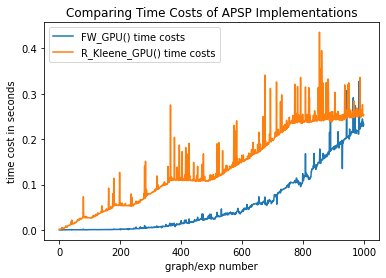

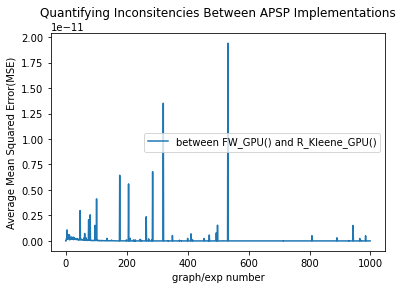

In [4]:
do_nx = True
sort_by_and_plot(big_dict, sort_by='nodes', do_nx=False, exp_slice=None)

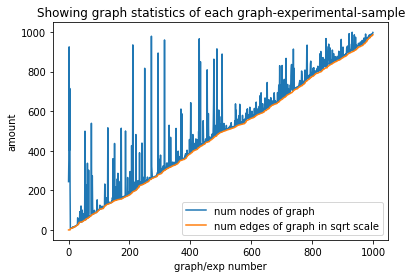

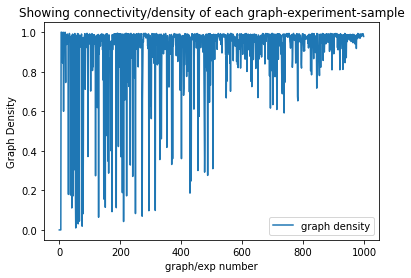

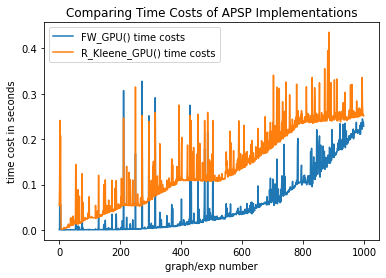

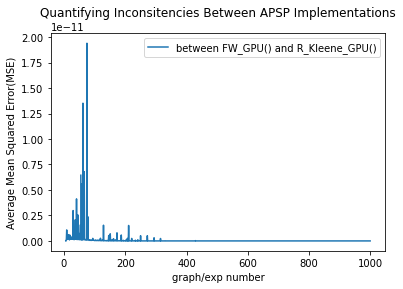

In [5]:
sort_by_and_plot(big_dict, sort_by='edges', do_nx=False, exp_slice=None)

In [5]:
from apsp import FW_iter
FW_iter(A)

(tensor([[ 0.,  5.,  8., 10.],
         [inf,  0.,  3.,  4.],
         [inf, inf,  0.,  1.],
         [inf, inf, inf,  0.]]),
 tensor([[0, 0, 1, 0],
         [0, 1, 1, 2],
         [0, 0, 2, 2],
         [0, 0, 0, 3]]))